**Выбор оптимального тарифного плана А1 (Беларусь) корпоративной линейки "Своё решение"**
*Февраль 2024*

**Предобработка данных**

*Импорт необходимых библиотек*

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import openpyxl

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Устанавливаем стиль визуализации по умолчанию для seaborn
sns.set()

import warnings

# Игнорирование конкретного предупреждения из библиотеки openpyxl
warnings.filterwarnings("ignore", message="Workbook contains no default style, apply openpyxl's default")

*Формирования датафрейма с действующими тарифами*

In [2]:
# Действующие тарифы А1 "Своё решение" для корпоративных клиентов
tariffs_options = {
    'Лидер': [
        {'minutes': 'unlimited', 'gb': 30, 'price': 33.81},
        {'minutes': 1200, 'gb': 40, 'price': 33.81},
        {'minutes': 1000, 'gb': 50, 'price': 33.81},
        {'minutes': 800, 'gb': 'unlimited', 'price': 33.81},
    ],
    'Эксперт': [
        {'minutes': 'unlimited', 'gb': 20, 'price': 27.37},
        {'minutes': 800, 'gb': 30, 'price': 27.37},
        {'minutes': 600, 'gb': 40, 'price': 27.37},
        {'minutes': 400, 'gb': 'unlimited', 'price': 27.37},
    ],
    'Мастер': [
        {'minutes': 'unlimited', 'gb': 0, 'price': 19.93},
        {'minutes': 500, 'gb': 5, 'price': 19.93},
        {'minutes': 300, 'gb': 15, 'price': 19.93},
        {'minutes': 100, 'gb': 25, 'price': 19.93},
    ],
    'Новатор': [
        {'minutes': 200, 'gb': 0, 'price': 10.50},
        {'minutes': 100, 'gb': 5, 'price': 10.50},
        {'minutes': 0, 'gb': 10, 'price': 10.50},
    ],
    'Передача данных': [
        {'minutes': 0, 'gb': 0, 'price': 2.06}  # Специальный тариф
    ]
}


# Создание DataFrame для хранения информации о сверхлимитных ставках для каждого тарифа
overlimit_rates = {
    "Тариф": ["Лидер", "Эксперт", "Мастер", "Новатор"] * 3,
    "Услуга": ["Интернет-трафик", "Исходящие внутри сети и на голосовую почту", "SMS исходящие международные"] * 4,
    "Цена за единицу": [
        # Лидер, Эксперт, Мастер, Новатор
        0.0596, 0.06, 0.185,
        0.0596, 0.06, 0.185,
        0.0596, 0.06, 0.185,
        0.0596, 0.06, 0.185,
    ]
}

# Преобразование словаря в DataFrame
overlimit_df = pd.DataFrame(overlimit_rates)

*Загрузка сырых данных*

Используем детализации, доступные в Личном Кабинете > Раздел "Финансы" > "Детализация на Email" в разрезе номеров и месяцев

In [3]:
# Установите путь к вашим файлам с сырыми данными
raw_data_path = './RAW/*.xlsx'  # Убедитесь, что путь указан корректно
files = glob.glob(raw_data_path)

# Список для хранения всех датафреймов с сырыми данными
raw_data = pd.DataFrame()

# Загрузка всех файлов Excel из директории
for file in files:
    df = pd.read_excel(file)
    # Добавление столбца с идентификатором файла, извлекаемым из имени файла
    df['Номер телефона'] = os.path.basename(file).split(' ')[0]
    raw_data = pd.concat([raw_data, df], ignore_index=True)  # Исправляем на правильное имя переменной
    
# Преобразование типов данных
# Преобразование 'Дата звонка' в datetime
raw_data['Дата звонка'] = pd.to_datetime(raw_data['Дата звонка'])

# Преобразование 'Номер телефона', 'Кто звонил', и 'Куда звонил' в int
raw_data['Номер телефона'] = raw_data['Номер телефона'].astype('int64')
raw_data['Кто звонил'] = raw_data['Кто звонил'].astype('int64')

# Преобразование 'Длительность, сек.' из формата HH:MM:SS в секунды
def process_duration(row):
    if 'SMS' in row['Тип звонка']:
        # If the type of call is SMS, return the 'Длительность, сек.' as is.
        return row['Длительность, сек.']
    else:
        # Otherwise, convert the HH:MM:SS duration to seconds.
        h, m, s = row['Длительность, сек.'].split(':')
        return int(h) * 3600 + int(m) * 60 + int(s)

# Применяем функцию к каждой строке фрейма данных.
raw_data['Длительность, сек.'] = raw_data.apply(process_duration, axis=1)

In [4]:
# Проверка результата
#raw_data.info()

In [5]:
# Проверка результата
#raw_data.head(1)

*Загрузка справочника абонентов*

Получить можно в ЛК > Раздел "Абоненты" > Выгрузить в Excel

In [6]:
# Загрузка информации о пользователях и их текущих тарифах
accounts_df = pd.read_excel('accounts.xlsx')

# Преобразование 'Номер/Логин' к строковому типу и очистка от пробелов
accounts_df['Номер/Логин'] = accounts_df['Номер/Логин'].astype(str).str.strip()

# Преобразование 'SIM/Точка подключения' в int (если это возможно)
# Обратите внимание: если в этом столбце есть нечисловые значения, преобразование вызовет ошибку
accounts_df['SIM/Точка подключения'] = pd.to_numeric(accounts_df['SIM/Точка подключения'], errors='coerce')

# Заполнение NaN значений, если они есть, после попытки конвертации
accounts_df['SIM/Точка подключения'] = accounts_df['SIM/Точка подключения'].fillna(0).astype(int)

# Преобразование DataFrame в словарь
accounts_info = accounts_df.set_index('Номер/Логин').to_dict('index')


In [7]:
# Проверка результата
#accounts_df.info()

In [8]:
# Убедитесь, что 'Номер телефона' в raw_data и 'Номер/Логин' в accounts_df имеют одинаковый тип данных
raw_data['Номер телефона'] = raw_data['Номер телефона'].astype(str)

# Объединение основного датафрейма с информацией о пользователях
data = raw_data.merge(accounts_df, how='left', left_on='Номер телефона', right_on='Номер/Логин')

# Переименование столбцов и изменение порядка
data = data.rename(columns={'Имя': 'ФИО', 'Тариф': 'Тариф', 'Статус': 'Статус'})

# Добавление столбца 'Год звонка'
data['Год звонка'] = data['Дата звонка'].dt.year

# Добавление столбца 'Месяц звонка'
data['Месяц звонка'] = data['Дата звонка'].dt.month

data = data[['Номер телефона', 'ФИО', 'Тариф', 'Статус', 'Тип звонка', 'Год звонка', 'Месяц звонка', 'Дата звонка', 'Длительность, сек.', 'Объем, Кбайт', 'Куда звонил', 'Начислено']]

# Удаление одного из дублирующихся столбцов 'ФИО', если они идентичны
data = data.loc[:,~data.columns.duplicated()]

def classify_connection_type(row):
    if 'Интернет-трафик' in row['Тип звонка']:
        return 'Интернет-трафик'
    elif 'SMS входящие' in row['Тип звонка']:
        return 'Входящие SMS'
    elif 'SMS исходящие' in row['Тип звонка'] or 'SMS на сервисные номера компании' in row['Тип звонка']:
        return 'Исходящие SMS'
    elif 'Входящие' in row['Тип звонка']:
        return 'Входящие звонки'
    elif ('Исходящие' in row['Тип звонка'] or 
          'Бесплатные звонки' in row['Тип звонка'] or 
          'Звонки на справочные/ короткие номера' in row['Тип звонка'] or 
          'Международные звонки (СНГ)' in row['Тип звонка']):
        return 'Исходящие звонки'
    elif 'Звонки в ЗАГ' in row['Тип звонка'] or 'Команда' in row['Тип звонка']:
        return 'Звонки в ЗАГ'
    elif 'Переадресация на голосовую почту' in row['Тип звонка']:
        return 'Переадресация на голосовую почту'
    else:
        return 'Другое'

# Применяем обновленную функцию к каждой строке в DataFrame
data['Категория соединения'] = data.apply(classify_connection_type, axis=1)


def define_connection_type(row):
    category = row['Категория соединения'].lower()  # Приведение к нижнему регистру для унификации
    if 'sms' in category:
        return 'SMS'
    elif 'интернет-трафик' == category:
        return 'Трафик'
    elif 'звонки' in category or 'переадресация на голосовую почту' == category:
        return 'Звонки'
    else:
        return 'Другое'

# Применение исправленной функции к каждой строке DataFrame для обновления столбца 'Тип'
data['Тип'] = data.apply(define_connection_type, axis=1)

In [9]:
# Проверка результата
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Номер телефона        1987 non-null   object        
 1   ФИО                   1987 non-null   object        
 2   Тариф                 1987 non-null   object        
 3   Статус                1987 non-null   object        
 4   Тип звонка            1987 non-null   object        
 5   Год звонка            1987 non-null   int32         
 6   Месяц звонка          1987 non-null   int32         
 7   Дата звонка           1987 non-null   datetime64[ns]
 8   Длительность, сек.    1987 non-null   object        
 9   Объем, Кбайт          642 non-null    float64       
 10  Куда звонил           1987 non-null   object        
 11  Начислено             1987 non-null   float64       
 12  Категория соединения  1987 non-null   object        
 13  Тип               

In [10]:
# Список уникальных номеров телефонов в data
used_phones = data['Номер телефона'].unique()

# Список всех номеров телефонов в accounts_df
all_phones = accounts_df['Номер/Логин'].unique()

# Находим номера телефонов из accounts_df, которые не используются в data
unused_phones = all_phones[~np.isin(all_phones, used_phones)]

# Преобразование массива unused_phones обратно в список для фильтрации
unused_phones_list = unused_phones.tolist()

# Фильтрация accounts_df для нахождения ФИО по неиспользуемым номерам
unused_phones_with_names = accounts_df[accounts_df['Номер/Логин'].isin(unused_phones_list)][['Номер/Логин', 'Имя']]

# Проверка результата
#print(unused_phones_with_names)

In [11]:
# Базовый DataFrame для рассчёта Оптимального тарифа
user_info = accounts_df[['Номер/Логин', 'Имя', 'Тариф']].rename(columns={'Номер/Логин': 'Номер телефона', 'Имя': 'ФИО'})

In [12]:
# Создаем копию для исходящих звонков, исключая международные
outgoing_calls = data[(data['Категория соединения'] == 'Исходящие звонки') & 
                      (data['Тип звонка'] != 'Международные звонки (СНГ)')].copy()

# Конвертация длительности звонков из секунд в минуты
outgoing_calls['Длительность, мин'] = outgoing_calls['Длительность, сек.'] / 60

# Группировка по номеру телефона, году и месяцу звонка и расчет суммы длительности звонков за месяц
monthly_outgoing = outgoing_calls.groupby(['Номер телефона', 'Год звонка', 'Месяц звонка'])['Длительность, мин'].sum().reset_index()

# Расчет среднего значения суммарной длительности звонков в месяц для каждого абонента
average_monthly_outgoing = monthly_outgoing.groupby('Номер телефона')['Длительность, мин'].mean().reset_index()
average_monthly_outgoing.rename(columns={'Длительность, мин': 'Исходящие, мин (сред. в месяц)'}, inplace=True)

# Теперь у нас есть DataFrame average_monthly_outgoing с колонками 'Номер телефона' и 'Исходящие, мин (сред. в месяц)'
# Проверка результата
#average_monthly_outgoing.head(1)

In [13]:
# Фильтрация данных для получения только интернет-трафика
internet_traffic = data[data['Тип'] == 'Трафик'].copy()

# Конвертация объема данных из Кбайт в ГБ
internet_traffic['Объем, ГБ'] = internet_traffic['Объем, Кбайт'] / (1024**2)

# Группировка по номеру телефона, году и месяцу звонка и расчет суммы трафика за месяц
monthly_traffic = internet_traffic.groupby(['Номер телефона', 'Год звонка', 'Месяц звонка'])['Объем, ГБ'].sum().reset_index()

# Расчет среднего значения объема трафика в месяц для каждого абонента
average_monthly_traffic = monthly_traffic.groupby('Номер телефона')['Объем, ГБ'].mean().reset_index()
average_monthly_traffic.rename(columns={'Объем, ГБ': 'Трафик, ГБ (сред. в месяц)'}, inplace=True)
average_monthly_traffic['Трафик, ГБ (сред. в месяц)'] = np.ceil(average_monthly_traffic['Трафик, ГБ (сред. в месяц)'])

# Теперь у нас есть DataFrame average_monthly_traffic с колонками 'Номер телефона' и 'Трафик, ГБ (сред. в месяц)'
# Проверка результата
#average_monthly_traffic.head(1)

In [14]:
# Добавление информации о среднемесячных исходящих минутах
user_info = user_info.merge(
    average_monthly_outgoing,
    on='Номер телефона',
    how='left'
)

# Добавление информации о среднемесячном трафике в ГБ
user_info = user_info.merge(
    average_monthly_traffic,
    on='Номер телефона',
    how='left'
)

# Замена NaN на 0 для случаев, когда данные отсутствуют
user_info.fillna(0, inplace=True)

# Проверка результата
#user_info.head(1)

In [15]:
def format_option(option):
    minutes = 'неограниченно' if option['minutes'] == 'unlimited' else f"{option['minutes']} мин"
    gb = 'неограниченно' if option['gb'] == 'unlimited' else f"{option['gb']} Гб"
    return f"{minutes}, {gb}"

def find_optimal_tariff_and_options(row):
    # Проверяем, не является ли текущий тариф специализированным для передачи данных
    if 'Передача данных' in row['Тариф']:
        # Если это специализированный тариф для передачи данных, возвращаем его стоимость
        data_tariff_cost = tariffs_options['Передача данных'][0]['price']
        return row['Тариф'], "Спец. тариф для данных", data_tariff_cost

    # Если это не специализированный тариф, вычисляем оптимальный тариф
    usage = {'minutes': row['Исходящие, мин (сред. в месяц)'], 'gb': row['Трафик, ГБ (сред. в месяц)']}
    optimal_choice = {'tariff': None, 'option': None, 'total_cost': float('inf')}
    
    # Исключаем из рассмотрения тариф "Передача данных"
    for tariff_name, options in {k: v for k, v in tariffs_options.items() if k != 'Передача данных'}.items():
        for option in options:
            minutes_limit = float('inf') if option['minutes'] == 'unlimited' else option['minutes']
            gb_limit = float('inf') if option['gb'] == 'unlimited' else option['gb']
            extra_minutes_cost = 0 if usage['minutes'] <= minutes_limit else (usage['minutes'] - minutes_limit) * 0.1
            extra_gb_cost = 0 if usage['gb'] <= gb_limit else (usage['gb'] - gb_limit) * 2
            total_cost = option['price'] + extra_minutes_cost + extra_gb_cost
            if total_cost < optimal_choice['total_cost']:
                optimal_choice = {
                    'tariff': tariff_name,
                    'option': format_option(option),
                    'total_cost': total_cost
                }
    return optimal_choice['tariff'], optimal_choice['option'], optimal_choice['total_cost']


# Применение функции к DataFrame и создание новых столбцов
user_info[['Оптимальный тариф', 'Опция внутри тарифа', 'Стоимость тарифа']] = user_info.apply(find_optimal_tariff_and_options, axis=1, result_type='expand')

In [16]:
# Список всех абонентов из accounts_df
all_phones_set = set(accounts_df['Номер/Логин'].astype(str))

# Список абонентов, по которым есть данные в data
active_phones_set = set(data['Номер телефона'].astype(str))

# Добавление статуса в user_info на основе проверки наличия номера в active_phones_set
user_info['Статус'] = user_info['Номер телефона'].apply(lambda x: 'Активный' if x in active_phones_set else 'Неактивный')

In [17]:
# Группировка по номеру телефона и подсчет уникальных месяцев за каждый год
months_active = data.groupby('Номер телефона').apply(lambda x: x[['Год звонка', 'Месяц звонка']].drop_duplicates().shape[0]).reset_index(name='Активных месяцев')

# Объединение с user_info
user_info = user_info.merge(months_active, on='Номер телефона', how='left')

# Заполнение пропущенных значений нулями для абонентов без данных
user_info['Активных месяцев'] = user_info['Активных месяцев'].fillna(0)

In [18]:
# Вывод результата
user_info.head()

,Номер телефона,ФИО,Тариф,"Исходящие, мин (сред. в месяц)","Трафик, ГБ (сред. в месяц)",Оптимальный тариф,Опция внутри тарифа,Стоимость тарифа,Статус,Активных месяцев
0,375291000001,Абонент 01,Своё решение. Новатор,0.0,0.0,Новатор,"200 мин, 0 Гб",10.50,Неактивный,0.0
1,375291000002,Абонент 02,Своё решение. Новатор,0.0,0.0,Новатор,"200 мин, 0 Гб",10.50,Неактивный,0.0
2,375291000003,Абонент 03,Своё решение. Новатор,303.0,0.0,Мастер,"неограниченно, 0 Гб",19.93,Активный,1.0
3,375291000004,Абонент 04,Своё решение. Мастер,0.0,0.0,Новатор,"200 мин, 0 Гб",10.50,Неактивный,0.0
4,375291000005,Абонент 05,Своё решение. Мастер,160.0,0.0,Новатор,"200 мин, 0 Гб",10.50,Активный,1.0


In [19]:
# Указываем имя файла для сохранения
excel_filename = "user_info_optimal_tariff.xlsx"

# Сохранение DataFrame в Excel
user_info.to_excel(excel_filename, index=False)

# Вывод сообщения об успешном сохранении файла
print(f"Файл '{excel_filename}' успешно сохранен.")

Файл 'user_info_optimal_tariff.xlsx' успешно сохранен.


**Анализ распределения пользователей по тарифам и статусам**

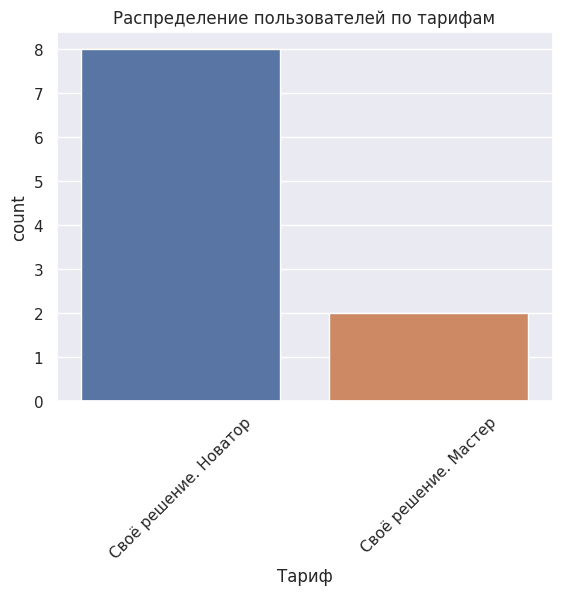

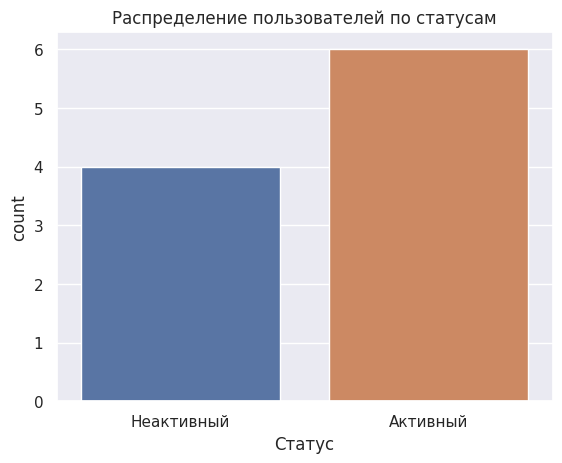

In [20]:
# Распределение пользователей по тарифам
sns.countplot(data=user_info, x='Тариф')
plt.title('Распределение пользователей по тарифам')
plt.xticks(rotation=45)
plt.show()

# Распределение пользователей по статусам
sns.countplot(data=user_info, x='Статус')
plt.title('Распределение пользователей по статусам')
plt.show()

**Анализ потребления (минуты, трафик)**

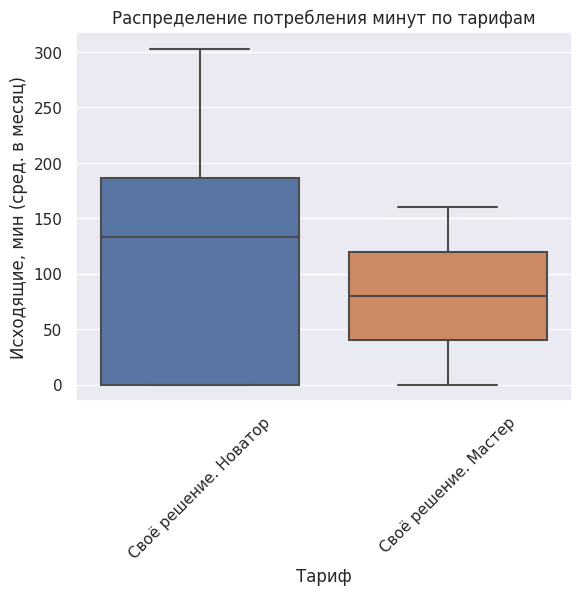

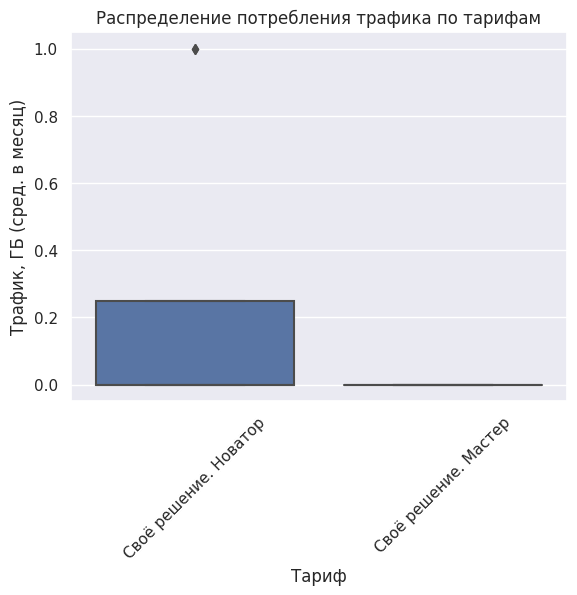

In [21]:
# Распределение потребления минут
sns.boxplot(data=user_info, x='Тариф', y='Исходящие, мин (сред. в месяц)')
plt.title('Распределение потребления минут по тарифам')
plt.xticks(rotation=45)
plt.show()

# Распределение потребления трафика
sns.boxplot(data=user_info, x='Тариф', y='Трафик, ГБ (сред. в месяц)')
plt.title('Распределение потребления трафика по тарифам')
plt.xticks(rotation=45)
plt.show()


**Сравнение расходов на текущих и оптимальных тарифах**

In [22]:
# Добавление стоимости текущего тарифа к user_info
tariff_prices = {tariff: options[0]['price'] for tariff, options in tariffs_options.items()}

# Определение функции для получения текущей стоимости тарифа
def get_tariff_price(tariff_name):
    # Если тариф специальный для передачи данных
    if 'Передача данных' in tariff_name:
        return tariffs_options['Передача данных'][0]['price']
    
    # Для стандартных тарифов удаляем "Своё решение. " и возвращаем стоимость
    tariff_name_cleaned = tariff_name.replace("Своё решение. ", "")
    if tariff_name_cleaned in tariffs_options:
        return tariffs_options[tariff_name_cleaned][0]['price']
    return 0  # Возвращаем 0, если тариф не найден

# Применяем функцию к столбцу 'Тариф'
user_info['Текущая стоимость тарифа'] = user_info['Тариф'].apply(get_tariff_price)

# Расчет суммарных начислений для каждого пользователя из данных детализации
total_charges = data.groupby('Номер телефона')['Начислено'].sum().reset_index()
total_charges.rename(columns={'Начислено': 'Суммарные начисления'}, inplace=True)

# Объединение информации о пользователях с суммарными начислениями
user_info = user_info.merge(total_charges, on='Номер телефона', how='left')

# Расчет текущих расходов как суммы абонентской платы и суммарных начислений
user_info['Текущие расходы'] = user_info['Текущая стоимость тарифа'] + user_info['Суммарные начисления'].fillna(0)

# Добавление стоимости оптимального тарифа из предыдущего расчета
# Предположим, что стоимость оптимального тарифа уже добавлена в user_info как 'Стоимость тарифа'

# Расчет разницы в расходах
user_info['Разница в расходах'] = user_info['Текущие расходы'] - user_info['Стоимость тарифа']

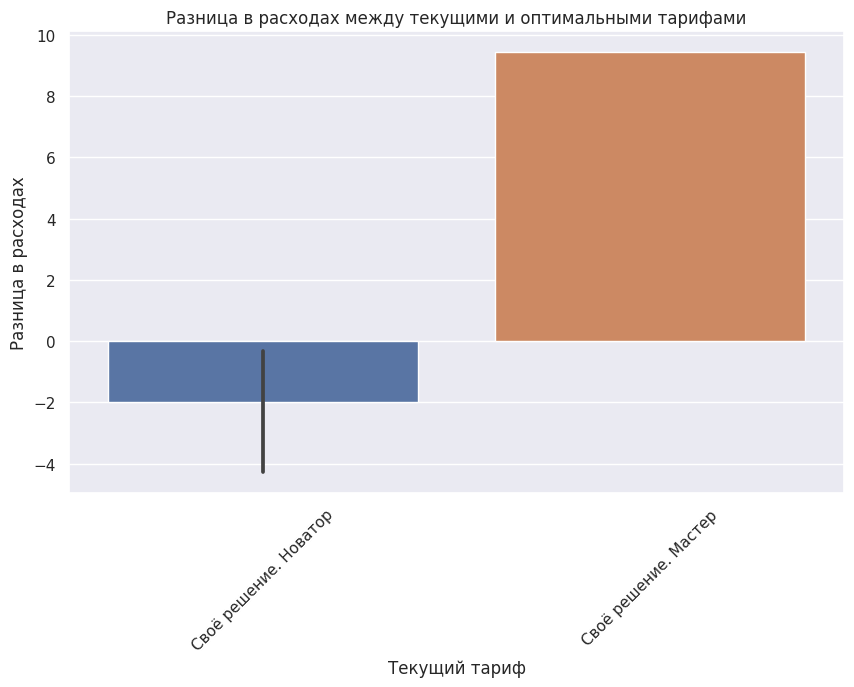

In [23]:
# Визуализация разницы в расходах
plt.figure(figsize=(10, 6))
sns.barplot(data=user_info, x='Тариф', y='Разница в расходах')
plt.title('Разница в расходах между текущими и оптимальными тарифами')
plt.xticks(rotation=45)
plt.ylabel('Разница в расходах')
plt.xlabel('Текущий тариф')
plt.show()


**Сегментация пользователей**

/home/md/.local/lib/python3.10/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/md/.local/lib/python3.10/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/md/.local/lib/python3.10/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


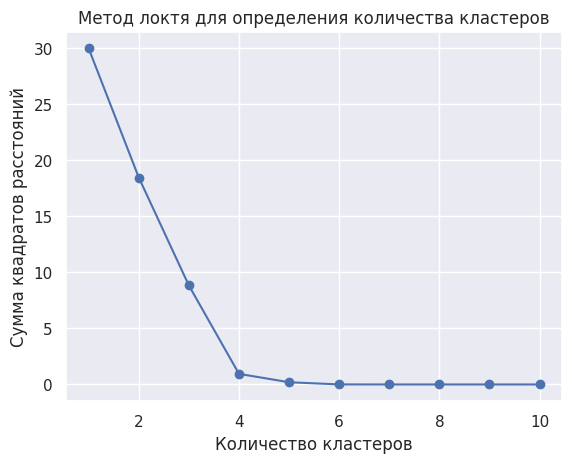

In [24]:
# Выбираем данные для кластеризации
X = user_info[['Исходящие, мин (сред. в месяц)', 'Трафик, ГБ (сред. в месяц)', 'Суммарные начисления']].fillna(0)

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia = []
for n_clusters in range(1, 11):
    # Явное указание n_init=10 для предотвращения предупреждений
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Метод локтя для определения количества кластеров')
plt.xlabel('Количество кластеров')
plt.ylabel('Сумма квадратов расстояний')
plt.show()

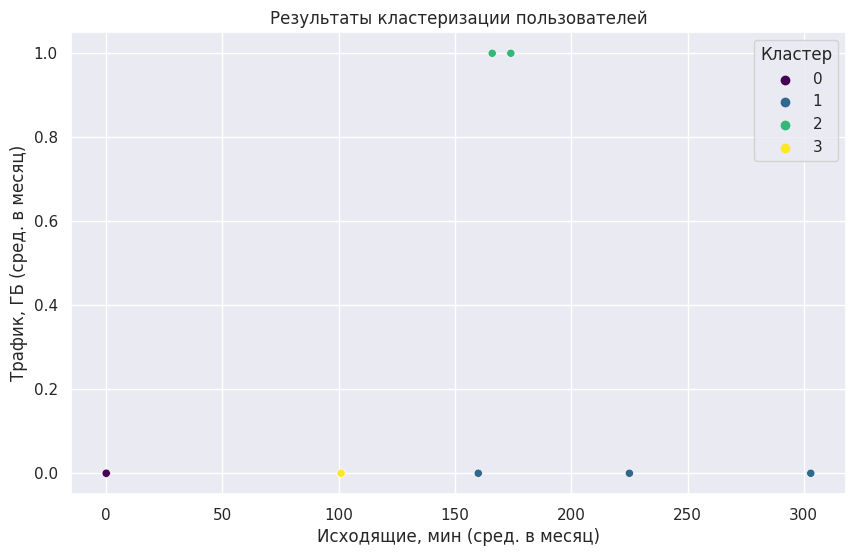

In [25]:
# Применяем K-means с выбранным количеством кластеров
optimal_clusters = 4  # Примерное оптимальное количество кластеров
kmeans = KMeans(n_clusters=optimal_clusters, n_init=10, random_state=42)  # Явно указываем n_init=10
user_info['Кластер'] = kmeans.fit_predict(X_scaled)

# Визуализация результатов кластеризации
plt.figure(figsize=(10, 6))
sns.scatterplot(data=user_info, x='Исходящие, мин (сред. в месяц)', y='Трафик, ГБ (сред. в месяц)', hue='Кластер', palette='viridis')
plt.title('Результаты кластеризации пользователей')
plt.show()

In [26]:
# Анализ средних значений признаков по кластерам
cluster_means = user_info.groupby('Кластер')[['Исходящие, мин (сред. в месяц)', 'Трафик, ГБ (сред. в месяц)', 'Суммарные начисления']].mean()

# Добавление информации о количестве абонентов в каждом кластере
cluster_sizes = user_info.groupby('Кластер').size().reset_index(name='Количество абонентов')

# Определение наиболее часто встречающегося оптимального тарифа в каждом кластере
cluster_optimal_tariffs = user_info.groupby('Кластер')['Оптимальный тариф'].agg(lambda x: x.mode()[0]).reset_index(name='Оптимальный тариф для кластера')

# Соединение данных о средних значениях и количестве абонентов
cluster_analysis = cluster_means.merge(cluster_sizes, on='Кластер')

# Добавление информации об оптимальном тарифе
cluster_analysis = cluster_analysis.merge(cluster_optimal_tariffs, on='Кластер')

# Вывод результата
cluster_analysis

,Кластер,"Исходящие, мин (сред. в месяц)","Трафик, ГБ (сред. в месяц)",Суммарные начисления,Количество абонентов,Оптимальный тариф для кластера
0,0,0.000000,0.0,NaN,4,Новатор
1,1,229.333333,0.0,0.00,3,Новатор
2,2,170.000000,1.0,0.00,2,Новатор
3,3,101.000000,0.0,0.06,1,Новатор
